#Team Details :
## CS23MTECH11020 - Suryansh Gautam
## CS23MTECH11008 - V Harikrishnan
## CS23MTECH11029 - Patel Heetkumar D.
## CS23MTECH13001 - Anil kumar Sharma
## CS23MTECH13002 - KR Anuraj



Google Drive mounting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive

/content/drive/My Drive


Importing necessary libraries

In [ ]:
import torch.nn as nn
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from torch.optim import Adam
import seaborn as sns
import matplotlib.pyplot as plt

Reading dataset and preprocessing it

In [ ]:
data_pd=pd.read_csv('card_transaction.v1.csv')

In [ ]:
print(data_pd.columns)

Index(['User', 'Card', 'Year', 'Month', 'Day', 'Time', 'Amount', 'Use Chip',
       'Merchant Name', 'Merchant City', 'Merchant State', 'Zip', 'MCC',
       'Errors?', 'Is Fraud?'],
      dtype='object')


In [ ]:
columns_to_encode =list(data_pd.columns)
data_pd['Amount'] = data_pd['Amount'].str.replace('$', '').astype(float)
columns_to_skip={'Amount'}
label_encoders={}

In [ ]:
for column in columns_to_encode:
  if column not in columns_to_skip:
    label_encoders[column] = LabelEncoder()
    data_pd[column + '_encoded'] = label_encoders[column].fit_transform(data_pd[column])
    data_pd.drop(columns=[column], inplace=True)

In [ ]:
data_pd = data_pd.fillna(data_pd.mean())

In [ ]:
print(data_pd.columns)

Index(['Amount', 'User_encoded', 'Card_encoded', 'Year_encoded',
       'Month_encoded', 'Day_encoded', 'Time_encoded', 'Use Chip_encoded',
       'Merchant Name_encoded', 'Merchant City_encoded',
       'Merchant State_encoded', 'Zip_encoded', 'MCC_encoded',
       'Errors?_encoded', 'Is Fraud?_encoded'],
      dtype='object')


In [ ]:
print(data_pd.iloc[11])

Amount                       53.91
User_encoded                  0.00
Card_encoded                  0.00
Year_encoded                  7.00
Month_encoded                 8.00
Day_encoded                   4.00
Time_encoded               1242.00
Use Chip_encoded              1.00
Merchant Name_encoded       154.00
Merchant City_encoded         0.00
Merchant State_encoded      144.00
Zip_encoded               15352.00
MCC_encoded                  45.00
Errors?_encoded              20.00
Is Fraud?_encoded             0.00
Name: 11, dtype: float64


In [ ]:
def normalize(df):
    return (df - df.min()) / (df.max() - df.min())

def denormalize(df_norm, df_original):
    return df_norm * (df_original.max() - df_original.min()) + df_original.min()

In [ ]:
df_normalized = normalize(data_pd)

Custom Dataset class to load data from CSV file


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_pd, transform=None):
        self.data = data_pd;
        self.transform=transform


    def __len__(self):
      return len(self.data)


    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        features = torch.tensor(sample, dtype=torch.float32)
        if self.transform:
            features = self.transform(features)
        return features

In [ ]:
dataset = CustomDataset(df_normalized)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Variational Autoencode model

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_dim=15, hidden_dim=12, latent_dim=8, device=device):
        super(VariationalAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.ReLU()
        )

        self.latent_dim = latent_dim

    def encode(self, input_data):
        encoded_output = self.encoder(input_data)
        mean, logvar = torch.chunk(encoded_output, 2, dim=1)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        epsilon = torch.randn_like(mean).to(mean.device)
        sampled_latent = mean + torch.exp(0.5 * logvar) * epsilon
        return sampled_latent

    def decode(self, sampled_latent):
        reconstructed_output = self.decoder(sampled_latent)
        return reconstructed_output

    def forward(self, input_data):
        mean, logvar = self.encode(input_data)
        sampled_latent = self.reparameterization(mean, logvar)
        reconstructed_output = self.decode(sampled_latent)
        return reconstructed_output, mean, logvar


Loss function

In [ ]:
def loss_function(x, x_hat, mean, log_var):
    reconstruction_loss = torch.mean(torch.square(x_hat - x))
    total_loss = reconstruction_loss
    return total_loss

Training Variational Autoencoder

In [ ]:
model = VariationalAutoencoder().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
epochs=10
max_grad_norm = 1.0

In [ ]:
print(len(dataloader))

9982


In [ ]:
model.train()

for epoch in range(epochs):
    epoch_loss = 0

    for batch_idx, x in enumerate(dataloader):
        x = x.to(device)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)


        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()

        epoch_loss += loss.item()

    average_loss = epoch_loss / len(dataloader.dataset)
    print(f"Epoch {epoch + 1}\tAverage Loss: {average_loss}")


Epoch 1	Average Loss: 5.673389826323993e-05
Epoch 2	Average Loss: 2.4831210586657548e-05
Epoch 3	Average Loss: 2.4670730219550875e-05
Epoch 4	Average Loss: 2.4637248475555786e-05
Epoch 5	Average Loss: 2.4620787989718938e-05
Epoch 6	Average Loss: 2.4612877791504757e-05
Epoch 7	Average Loss: 2.462326993181376e-05
Epoch 8	Average Loss: 2.462382676025e-05
Epoch 9	Average Loss: 2.4584815360316784e-05
Epoch 10	Average Loss: 2.4585040019804815e-05


Model evaluation

In [ ]:
model.eval()

original_input_array = df_normalized[:2000000].values.astype(np.float32)

original_input_tensor = torch.tensor(original_input_array).to(device)

with torch.no_grad():
    reconstructed_samples, _, _ = model(original_input_tensor)

synthetic_samples = reconstructed_samples.cpu().numpy()

In [ ]:
synthetic_samples[2:10]

array([[0.07496031, 0.00251094, 0.1920599 , 0.5686622 , 0.73819256,
        0.03207567, 0.30223104, 0.6674545 , 0.4523475 , 0.5397014 ,
        0.10630414, 0.8963643 , 0.5318193 , 0.99887335, 0.        ],
       [0.07628321, 0.00378653, 0.15674523, 0.56999874, 0.73819464,
        0.03204879, 0.7731776 , 0.6675521 , 0.67405224, 0.54710776,
        0.10538498, 0.8961389 , 0.55890715, 1.0000991 , 0.        ],
       [0.07508533, 0.00640589, 0.1939574 , 0.5668681 , 0.7379028 ,
        0.06527486, 0.31000984, 0.6688169 , 0.8119522 , 0.43294567,
        0.10084856, 0.8843782 , 0.5444115 , 0.99896973, 0.        ],
       [0.07571696, 0.00873038, 0.16142713, 0.5687951 , 0.7376935 ,
        0.06486374, 0.6209077 , 0.66566503, 0.11608544, 0.5660812 ,
        0.09798935, 0.8802136 , 0.52813184, 0.99898046, 0.        ],
       [0.07493779, 0.00253329, 0.19365032, 0.56858134, 0.73810107,
        0.09870309, 0.2814902 , 0.6673385 , 0.45235872, 0.5391943 ,
        0.10600409, 0.89621866, 0.53107935, 

In [ ]:
result=pd.DataFrame(synthetic_samples)
result.columns=data_pd.columns

PLotting the synthetically generated data

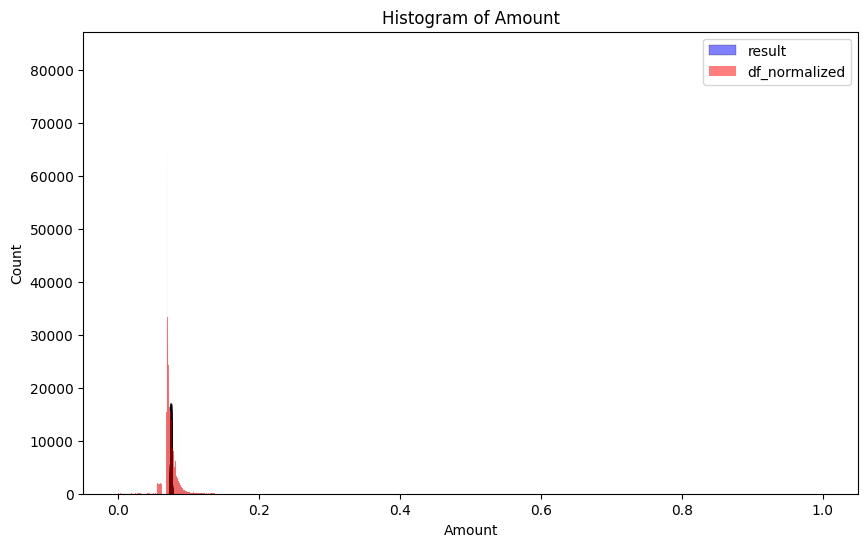

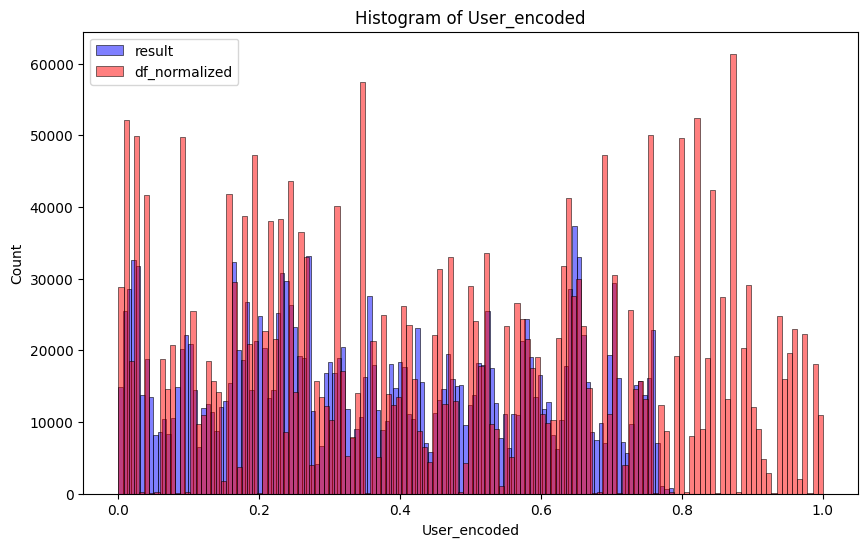

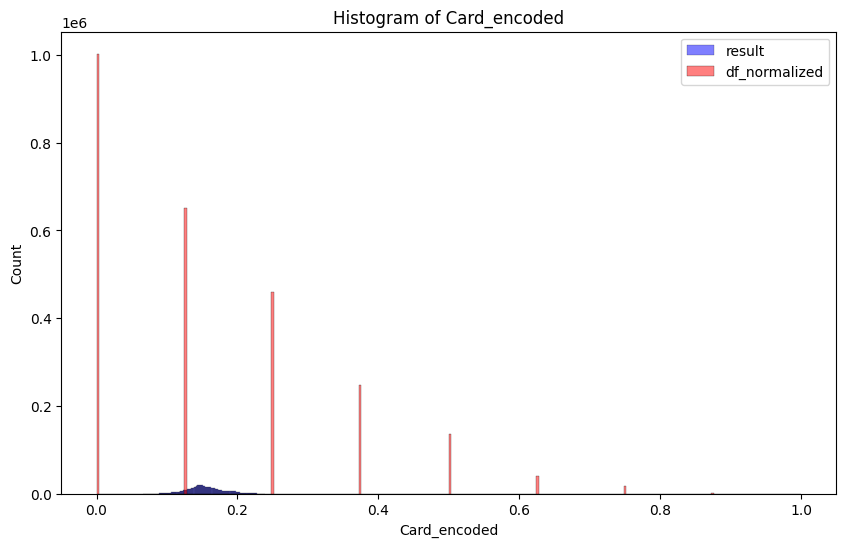

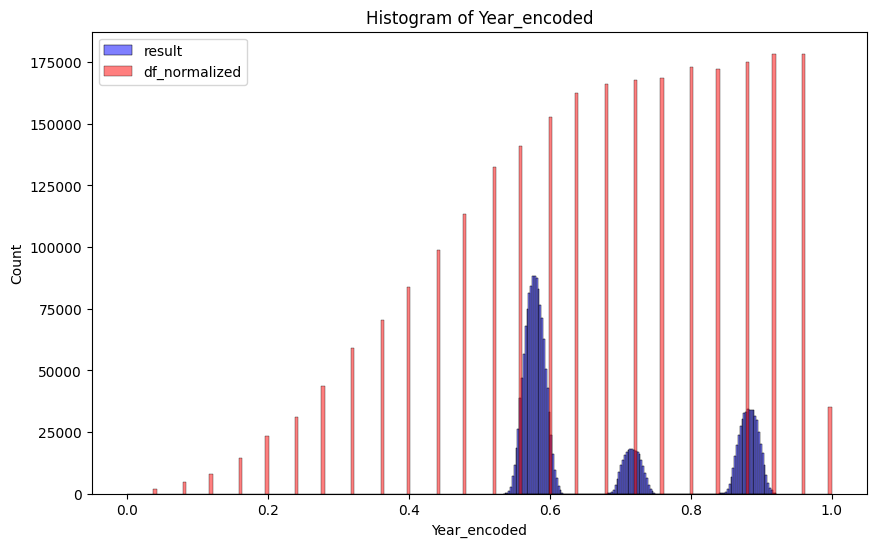

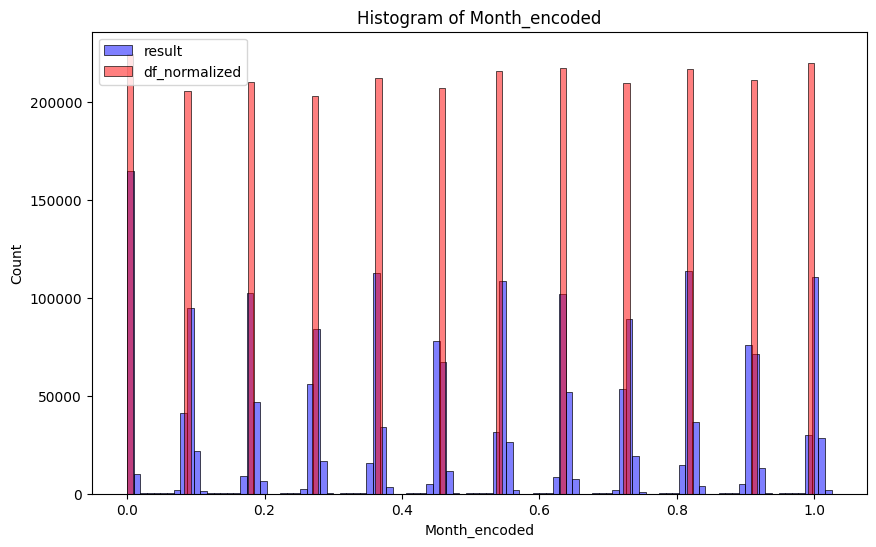

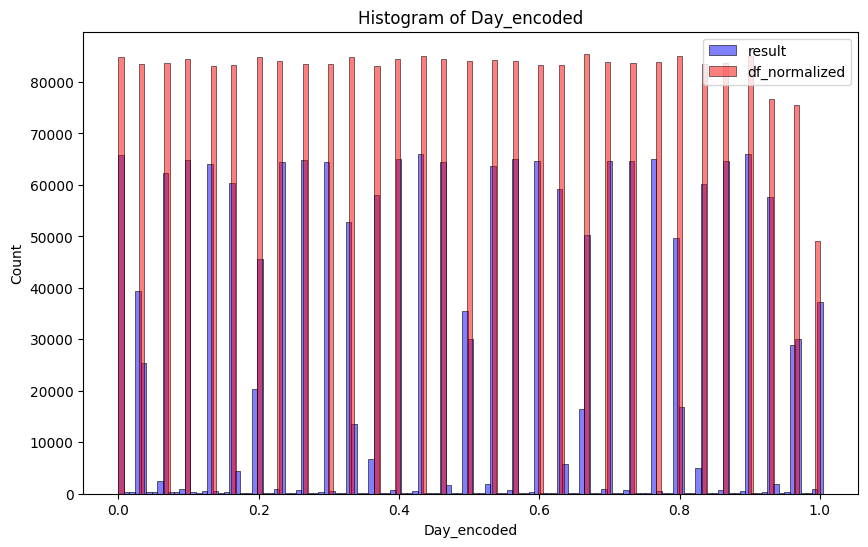

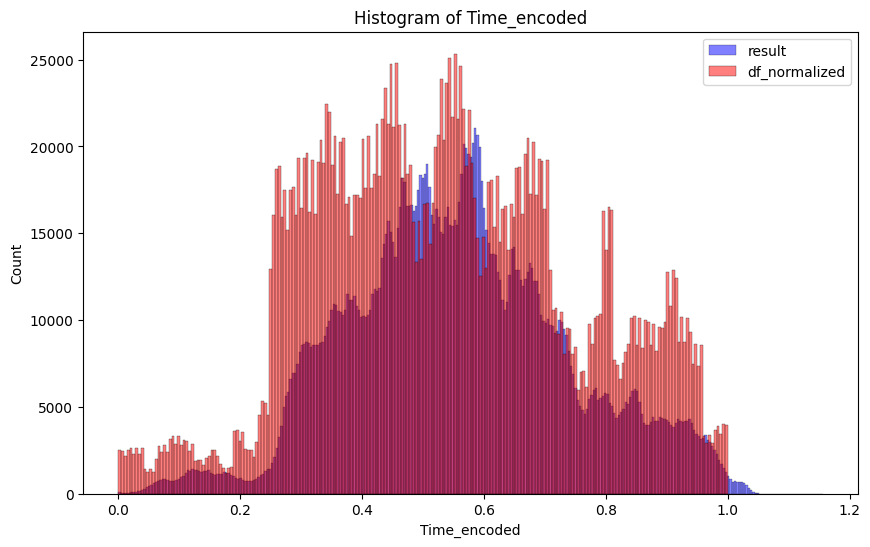

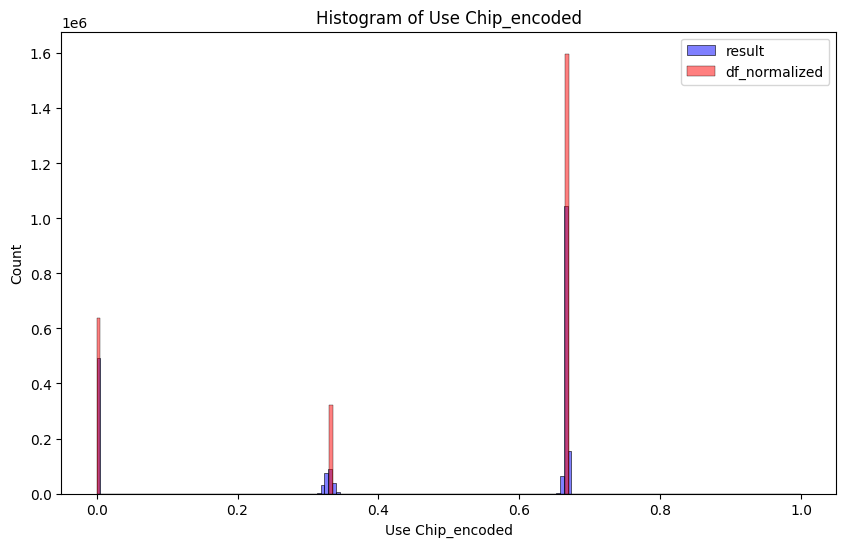

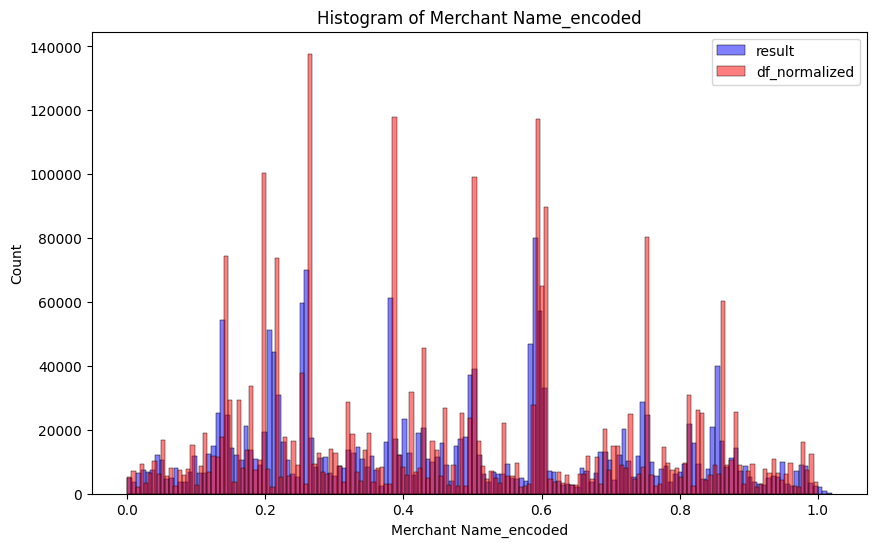

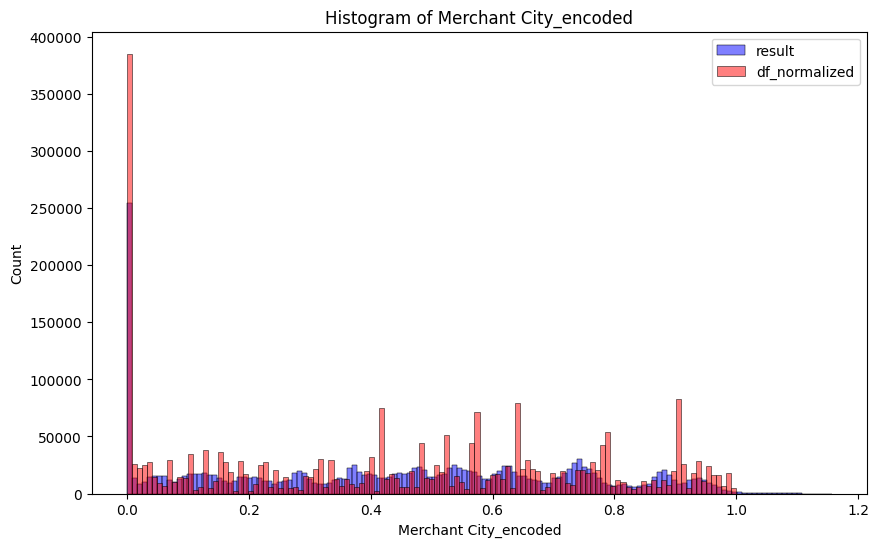

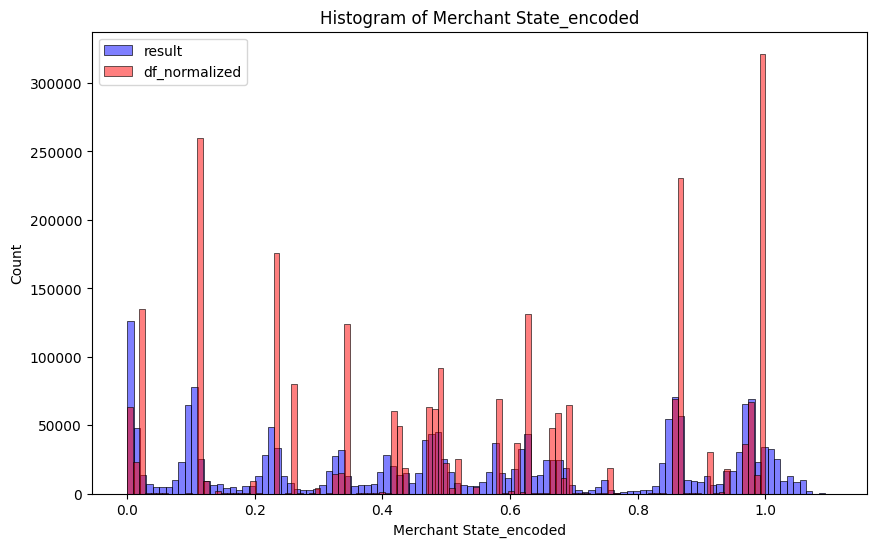

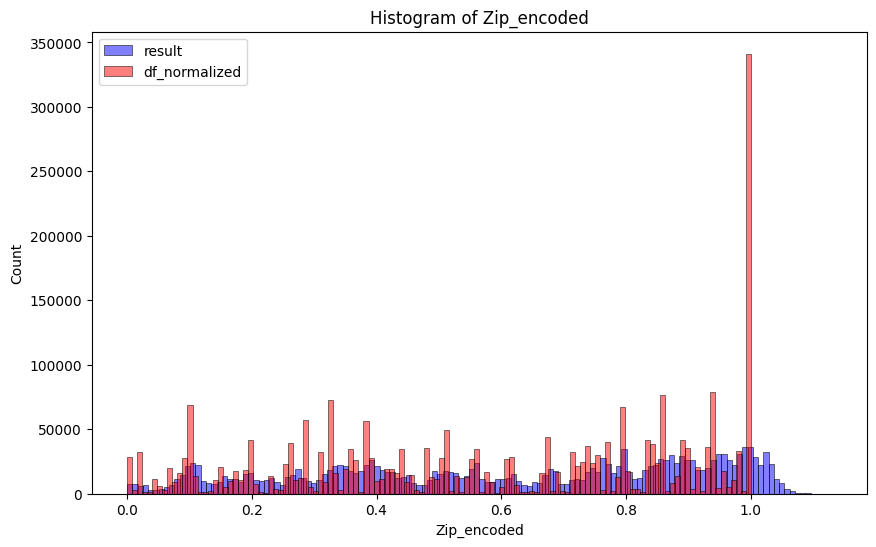

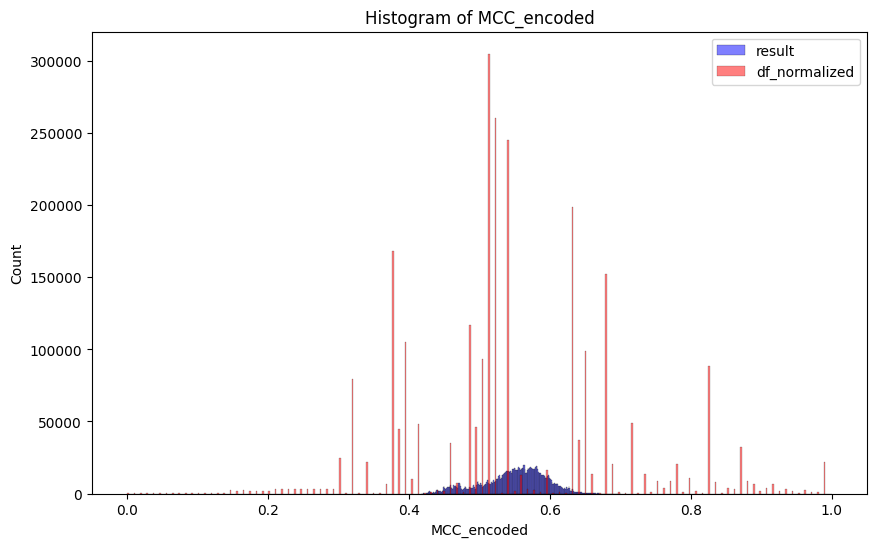

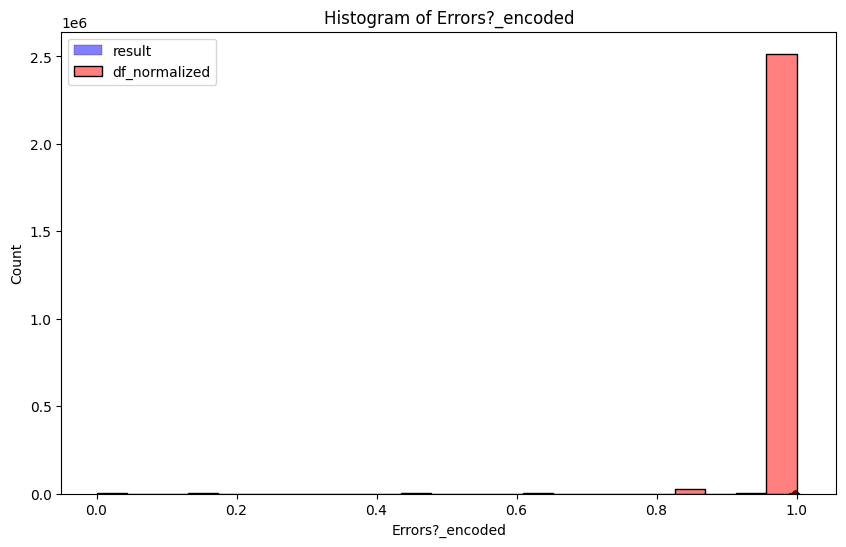

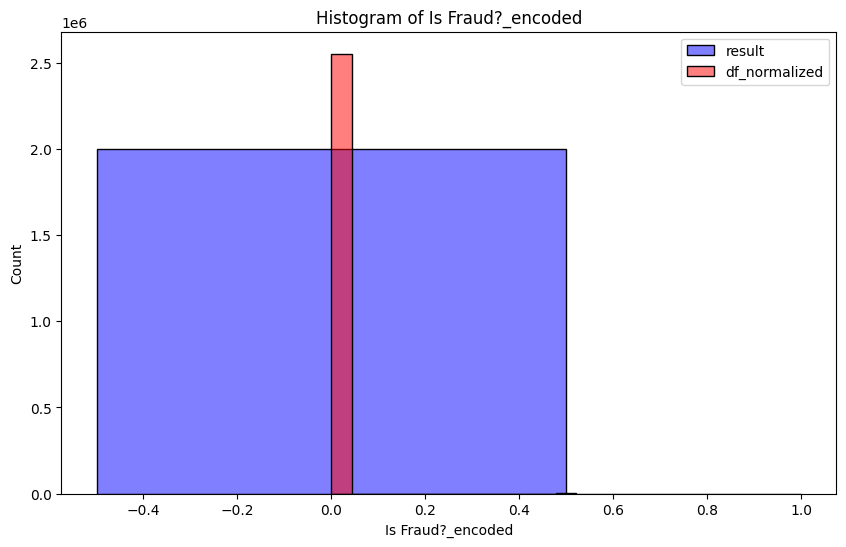

In [ ]:
for column in result.select_dtypes(include='number'):
    plt.figure(figsize=(10, 6))
    sns.histplot(result[column], color='blue', alpha=0.5, label='result')
    sns.histplot(df_normalized[column], color='red', alpha=0.5, label='df_normalized')
    plt.title(f'Histogram of {column}')
    plt.legend()
    plt.show()

In [ ]:
num_duplicates = result.duplicated().sum()

print("Number of duplicate rows:", num_duplicates)

Number of duplicate rows: 0


In [ ]:
print("Number of duplicate rows in original: ", df_normalized.duplicated().sum())

Number of duplicate rows in original:  7


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


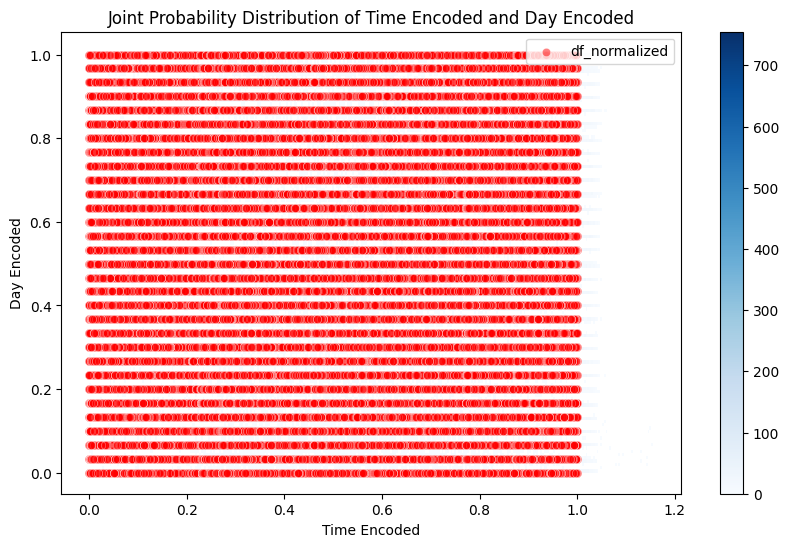

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(x=result['Time_encoded'], y=result['Day_encoded'], cmap='Blues', cbar=True)
sns.scatterplot(x=df_normalized['Time_encoded'], y=df_normalized['Day_encoded'], color='red', alpha=0.5, label='df_normalized')
plt.xlabel("Time Encoded")
plt.ylabel("Day Encoded")
plt.title(f'Joint Probability Distribution of Time Encoded and Day Encoded')
plt.legend()
plt.show()